# Sampling of Purification MPS
This notebook demonstrates how to sample basis states from a purification MPS to evaluate expectation values. While we demonstrate this for magnetization, a sum of local quantities $\langle Z_i \rangle$, sampling could be useful to stochastically evaluate non-local expectation values where contraction of the tensor network for exact evaluation is expensive. To demonstrate this functionality, we find the purification of the thermal density matrix $\rho \propto e^{-\beta H}$ for the transverse field Ising model as a function of inverse temperature $\beta$. We represent the density matrix as a purified pure state $|\psi \rangle$ on an enlarged Hilbert space $\mathcal{H}_p \otimes \mathcal{H}_a $ such that $\rho = \mathrm{Tr}_a |\psi \rangle \langle \psi |$.

The algorithm from sampling purification MPS is a simple extension of that for sampling MPS, explained in detail in the following two papers:
1. https://arxiv.org/abs/1002.1305
2. https://arxiv.org/abs/1201.3974

In [1]:
import numpy as np
import sys
from time import time

In [2]:
import tenpy
from tenpy.models.tf_ising import TFIChain
from tenpy.networks.purification_mps import PurificationMPS
from tenpy.algorithms.purification import PurificationTEBD, PurificationApplyMPO

/home/sajant/tenpy/tenpy/tools/optimization.py:317: UserWarning: Couldn't load compiled cython code. Code will run a bit slower.
  warnings.warn("Couldn't load compiled cython code. Code will run a bit slower.")


Run purification TEBD and measure magnetization on each site, both by contracting the tensor network (really by using orthogonality conditions to avoid most of the work) or sampling.

In [3]:
def imag_tebd(L=30, beta_max=3., dt=0.05, order=2, bc="finite", num_samples=1000, chi_max=100, sample_all=True):
    model_params = dict(L=L, J=1., g=1.2)
    M = TFIChain(model_params)
    psi = PurificationMPS.from_infiniteT(M.lat.mps_sites(), bc=bc)
    options = {
        'trunc_params': {
            'chi_max': chi_max,
            'svd_min': 1.e-8
        },
        'order': order,
        'dt': dt,
        'N_steps': 1
    }
    beta = 0.
    eng = PurificationTEBD(psi, M, options)
    Szs = [psi.expectation_value("Sz")]
    Szs_sample_sq, Szs_sample_nsq, sampling_time_sq, sampling_time_nsq = [], [], [], []
    if sample_all:
        sample_data = sample_purification(psi, num_samples)
        Szs_sample_sq.append(sample_data[0][0])
        Szs_sample_nsq.append(sample_data[1][0])
        sampling_time_sq.append(sample_data[0][2])
        sampling_time_nsq.append(sample_data[1][2])
    betas = [0.]
    psis = [psi.copy()]
    while beta < beta_max:
        beta += 2. * dt  # factor of 2:  |psi> ~= exp^{- dt H}, but rho = |psi><psi|
        betas.append(beta)
        eng.run_imaginary(dt)  # cool down by dt
        Szs.append(psi.expectation_value("Sz"))  # and further measurements...
        if sample_all or np.isclose(beta, beta_max):
            print(psi.chi)
            sample_data = sample_purification(psi, num_samples)
            Szs_sample_sq.append(sample_data[0][0])
            Szs_sample_nsq.append(sample_data[1][0])
            sampling_time_sq.append(sample_data[0][2])
            sampling_time_nsq.append(sample_data[1][2])
        psis.append(psi.copy())
    return {'beta': betas, 'Sz': Szs, 'Sz_sample_sq': Szs_sample_sq, 'Sz_sample_nsq': Szs_sample_nsq, 
            'time_sq': sampling_time_sq, 'time_nsq': sampling_time_nsq, 
            'psi': psis}

Below we repeatedly sample a purification MPS to determine the magnetization. Depending on the value of `sample_q`, we either sample the ancilla leg (`True`) or contract over it (`False`). The first is cheaper than the latter, with a cost of $\mathcal{}(\chi^2)$ compared to $\mathcal{}(\chi^3)$.

In [4]:
def sample_purification(psi, num_samples):
    data = []
    for sample_q in [True, False]:
        magnetization = []
        start_time = time()
        for i in range(num_samples):
            sigmas, total_prob = psi.sample_measurements(sample_q, complex_amplitude=False)
            magnetization.append(np.array(sigmas) - 1/2) # 1 index corresponds to spin up I guess
        sample_time = time() - start_time
        magnetization = np.row_stack(magnetization)
        data.append((magnetization.mean(axis=0), magnetization, sample_time / num_samples))
    return data

## Average magnetization as a function of $\beta$

In [5]:
import logging
logging.basicConfig(level=logging.INFO)
data_tebd = imag_tebd(L=30, beta_max=3.0, num_samples=50)

INFO:tenpy.tools.params:TFIChain: reading 'L'=30
INFO:tenpy.tools.params:TFIChain: reading 'J'=1.0
INFO:tenpy.tools.params:TFIChain: reading 'g'=1.2
INFO:tenpy.tools.params:PurificationTEBD: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:PurificationTEBD: reading 'dt'=0.05
INFO:tenpy.algorithms.tebd:Calculate U for {'order': 2, 'delta_t': 0.05, 'type_evo': 'imag', 'E_offset': None, 'tau': -0.05j}
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=100
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-08
INFO:tenpy.algorithms.purification:--> beta=0.050000, E_bond=-0.2460708907, max(S)=0.0172500676


[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


INFO:tenpy.algorithms.purification:--> beta=0.100000, E_bond=-0.4756494810, max(S)=0.0532230133


[4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]


INFO:tenpy.algorithms.purification:--> beta=0.150000, E_bond=-0.6767971387, max(S)=0.0967049734


[4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]


INFO:tenpy.algorithms.purification:--> beta=0.200000, E_bond=-0.8441540463, max(S)=0.1411322525


[4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4]


INFO:tenpy.algorithms.purification:--> beta=0.250000, E_bond=-0.9781014310, max(S)=0.1827168026


[4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4]


INFO:tenpy.algorithms.purification:--> beta=0.300000, E_bond=-1.0825193832, max(S)=0.2197692357


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4]


INFO:tenpy.algorithms.purification:--> beta=0.350000, E_bond=-1.1626430338, max(S)=0.2518978714


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4]


INFO:tenpy.algorithms.purification:--> beta=0.400000, E_bond=-1.2236704021, max(S)=0.2793931954


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 4]


INFO:tenpy.algorithms.purification:--> beta=0.450000, E_bond=-1.2701012984, max(S)=0.3028286284


[4, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 4]


INFO:tenpy.algorithms.purification:--> beta=0.500000, E_bond=-1.3055507972, max(S)=0.3228394786


[4, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.550000, E_bond=-1.3328003341, max(S)=0.3400180953


[4, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.600000, E_bond=-1.3539370350, max(S)=0.3548744861


[4, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.650000, E_bond=-1.3705056888, max(S)=0.3678296985


[4, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.700000, E_bond=-1.3836424298, max(S)=0.3792235056


[4, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 4]


INFO:tenpy.algorithms.purification:--> beta=0.750000, E_bond=-1.3941816805, max(S)=0.3893269224


[4, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 4]


INFO:tenpy.algorithms.purification:--> beta=0.800000, E_bond=-1.4027375341, max(S)=0.3983551258


[4, 14, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.850000, E_bond=-1.4097639705, max(S)=0.4064789719


[4, 14, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.900000, E_bond=-1.4155987119, max(S)=0.4138345776


[4, 14, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.950000, E_bond=-1.4204948992, max(S)=0.4205309982


[4, 15, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.000000, E_bond=-1.4246438890, max(S)=0.4266562471


[4, 15, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.050000, E_bond=-1.4281916571, max(S)=0.4322819578


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.100000, E_bond=-1.4312506260, max(S)=0.4374669712


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.150000, E_bond=-1.4339082234, max(S)=0.4422600875


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.200000, E_bond=-1.4362331074, max(S)=0.4467021777


[4, 16, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 22, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.250000, E_bond=-1.4382797204, max(S)=0.4508278067


[4, 16, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.300000, E_bond=-1.4400916437, max(S)=0.4546664848


[4, 16, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.350000, E_bond=-1.4417040858, max(S)=0.4582436383


[4, 16, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.400000, E_bond=-1.4431457429, max(S)=0.4615813653


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.450000, E_bond=-1.4444402010, max(S)=0.4646990279


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.500000, E_bond=-1.4456070009, max(S)=0.4676137204


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


Now let's plot the magnetization as a function of $\beta$. We see that the measurements from sampling agree with those from exact contraction.

/home/sajant/tenpy/tenpy/tools/params.py:232: UserWarning: unused options for config PurificationTEBD:
['N_steps', 'order']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


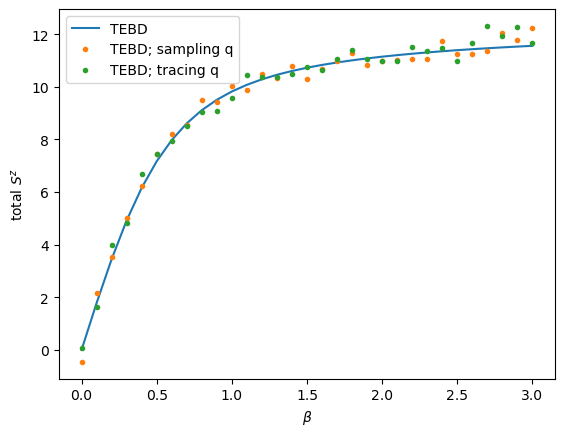

In [6]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(data_tebd['beta'], np.sum(data_tebd['Sz'], axis=1), label='TEBD')
plt.plot(data_tebd['beta'], np.sum(data_tebd['Sz_sample_sq'], axis=1), '.', label='TEBD; sampling q')
plt.plot(data_tebd['beta'], np.sum(data_tebd['Sz_sample_nsq'], axis=1), '.', label='TEBD; tracing q')

plt.legend()
plt.xlabel(r'$\beta$')
plt.ylabel(r'total $S^z$')
plt.show()

Now we look at sampling time as a function of $\beta$. We expect this to be independent of $\beta$ and only dependent on $\chi$.

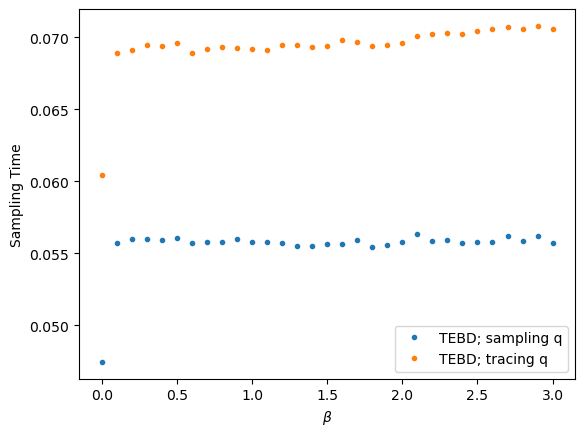

In [7]:
plt.plot(data_tebd['beta'], data_tebd['time_sq'], '.', label='TEBD; sampling q')
plt.plot(data_tebd['beta'], data_tebd['time_nsq'], '.', label='TEBD; tracing q')

plt.legend()
plt.xlabel(r'$\beta$')
plt.ylabel(r'Sampling Time')
plt.show()

## Sampling time dependence on chi

In [8]:
datas_tebd = {}
for chi in [2, 4, 8, 12, 16, 20, 24]:
    datas_tebd[chi] = imag_tebd(L=30, beta_max=3.0, num_samples=50, chi_max=chi, sample_all=False)

INFO:tenpy.tools.params:TFIChain: reading 'L'=30
INFO:tenpy.tools.params:TFIChain: reading 'J'=1.0
INFO:tenpy.tools.params:TFIChain: reading 'g'=1.2
INFO:tenpy.tools.params:PurificationTEBD: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:PurificationTEBD: reading 'dt'=0.05
INFO:tenpy.algorithms.tebd:Calculate U for {'order': 2, 'delta_t': 0.05, 'type_evo': 'imag', 'E_offset': None, 'tau': -0.05j}
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=2
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-08
INFO:tenpy.algorithms.purification:--> beta=0.050000, E_bond=-0.2460704684, max(S)=0.0172499542
INFO:tenpy.algorithms.purification:--> beta=0.100000, E_bond=-0.4756295855, max(S)=0.0532187236
INFO:tenpy.algorithms.purification:--> beta=0.150000, E_bond=-0.6766525889, max(S)=0.0966746449
INFO:tenpy.algorithms.purification:--> beta=0.200000, E_bond=-0.8436355045, max(S)=0.1410008935
INFO:tenpy.algorithms.purification:--> beta=0.250000, E_bo

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


INFO:tenpy.tools.params:TFIChain: reading 'L'=30
INFO:tenpy.tools.params:TFIChain: reading 'J'=1.0
INFO:tenpy.tools.params:TFIChain: reading 'g'=1.2
INFO:tenpy.tools.params:PurificationTEBD: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:PurificationTEBD: reading 'dt'=0.05
INFO:tenpy.algorithms.tebd:Calculate U for {'order': 2, 'delta_t': 0.05, 'type_evo': 'imag', 'E_offset': None, 'tau': -0.05j}
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=4
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-08
INFO:tenpy.algorithms.purification:--> beta=0.050000, E_bond=-0.2460708907, max(S)=0.0172500676
INFO:tenpy.algorithms.purification:--> beta=0.100000, E_bond=-0.4756494809, max(S)=0.0532230133
INFO:tenpy.algorithms.purification:--> beta=0.150000, E_bond=-0.6767971354, max(S)=0.0967049716
INFO:tenpy.algorithms.purification:--> beta=0.200000, E_bond=-0.8441540073, max(S)=0.1411322267
INFO:tenpy.algorithms.purification:--> beta=0.250000, E_bo

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


INFO:tenpy.tools.params:TFIChain: reading 'L'=30
INFO:tenpy.tools.params:TFIChain: reading 'J'=1.0
INFO:tenpy.tools.params:TFIChain: reading 'g'=1.2
INFO:tenpy.tools.params:PurificationTEBD: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:PurificationTEBD: reading 'dt'=0.05
INFO:tenpy.algorithms.tebd:Calculate U for {'order': 2, 'delta_t': 0.05, 'type_evo': 'imag', 'E_offset': None, 'tau': -0.05j}
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=8
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-08
INFO:tenpy.algorithms.purification:--> beta=0.050000, E_bond=-0.2460708907, max(S)=0.0172500676
INFO:tenpy.algorithms.purification:--> beta=0.100000, E_bond=-0.4756494810, max(S)=0.0532230133
INFO:tenpy.algorithms.purification:--> beta=0.150000, E_bond=-0.6767971387, max(S)=0.0967049734
INFO:tenpy.algorithms.purification:--> beta=0.200000, E_bond=-0.8441540463, max(S)=0.1411322525
INFO:tenpy.algorithms.purification:--> beta=0.250000, E_bo

[4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4]


INFO:tenpy.tools.params:TFIChain: reading 'L'=30
INFO:tenpy.tools.params:TFIChain: reading 'J'=1.0
INFO:tenpy.tools.params:TFIChain: reading 'g'=1.2
INFO:tenpy.tools.params:PurificationTEBD: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:PurificationTEBD: reading 'dt'=0.05
INFO:tenpy.algorithms.tebd:Calculate U for {'order': 2, 'delta_t': 0.05, 'type_evo': 'imag', 'E_offset': None, 'tau': -0.05j}
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=12
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-08
INFO:tenpy.algorithms.purification:--> beta=0.050000, E_bond=-0.2460708907, max(S)=0.0172500676
INFO:tenpy.algorithms.purification:--> beta=0.100000, E_bond=-0.4756494810, max(S)=0.0532230133
INFO:tenpy.algorithms.purification:--> beta=0.150000, E_bond=-0.6767971387, max(S)=0.0967049734
INFO:tenpy.algorithms.purification:--> beta=0.200000, E_bond=-0.8441540463, max(S)=0.1411322525
INFO:tenpy.algorithms.purification:--> beta=0.250000, E_b

[4, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 4]


INFO:tenpy.tools.params:TFIChain: reading 'L'=30
INFO:tenpy.tools.params:TFIChain: reading 'J'=1.0
INFO:tenpy.tools.params:TFIChain: reading 'g'=1.2
INFO:tenpy.tools.params:PurificationTEBD: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:PurificationTEBD: reading 'dt'=0.05
INFO:tenpy.algorithms.tebd:Calculate U for {'order': 2, 'delta_t': 0.05, 'type_evo': 'imag', 'E_offset': None, 'tau': -0.05j}
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=16
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-08
INFO:tenpy.algorithms.purification:--> beta=0.050000, E_bond=-0.2460708907, max(S)=0.0172500676
INFO:tenpy.algorithms.purification:--> beta=0.100000, E_bond=-0.4756494810, max(S)=0.0532230133
INFO:tenpy.algorithms.purification:--> beta=0.150000, E_bond=-0.6767971387, max(S)=0.0967049734
INFO:tenpy.algorithms.purification:--> beta=0.200000, E_bond=-0.8441540463, max(S)=0.1411322525
INFO:tenpy.algorithms.purification:--> beta=0.250000, E_b

[4, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 4]


INFO:tenpy.tools.params:TFIChain: reading 'L'=30
INFO:tenpy.tools.params:TFIChain: reading 'J'=1.0
INFO:tenpy.tools.params:TFIChain: reading 'g'=1.2
INFO:tenpy.tools.params:PurificationTEBD: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:PurificationTEBD: reading 'dt'=0.05
INFO:tenpy.algorithms.tebd:Calculate U for {'order': 2, 'delta_t': 0.05, 'type_evo': 'imag', 'E_offset': None, 'tau': -0.05j}
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=20
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-08
INFO:tenpy.algorithms.purification:--> beta=0.050000, E_bond=-0.2460708907, max(S)=0.0172500676
INFO:tenpy.algorithms.purification:--> beta=0.100000, E_bond=-0.4756494810, max(S)=0.0532230133
INFO:tenpy.algorithms.purification:--> beta=0.150000, E_bond=-0.6767971387, max(S)=0.0967049734
INFO:tenpy.algorithms.purification:--> beta=0.200000, E_bond=-0.8441540463, max(S)=0.1411322525
INFO:tenpy.algorithms.purification:--> beta=0.250000, E_b

[4, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 16, 4]


INFO:tenpy.tools.params:TFIChain: reading 'L'=30
INFO:tenpy.tools.params:TFIChain: reading 'J'=1.0
INFO:tenpy.tools.params:TFIChain: reading 'g'=1.2
INFO:tenpy.tools.params:PurificationTEBD: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:PurificationTEBD: reading 'dt'=0.05
INFO:tenpy.algorithms.tebd:Calculate U for {'order': 2, 'delta_t': 0.05, 'type_evo': 'imag', 'E_offset': None, 'tau': -0.05j}
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=24
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-08
INFO:tenpy.algorithms.purification:--> beta=0.050000, E_bond=-0.2460708907, max(S)=0.0172500676
INFO:tenpy.algorithms.purification:--> beta=0.100000, E_bond=-0.4756494810, max(S)=0.0532230133
INFO:tenpy.algorithms.purification:--> beta=0.150000, E_bond=-0.6767971387, max(S)=0.0967049734
INFO:tenpy.algorithms.purification:--> beta=0.200000, E_bond=-0.8441540463, max(S)=0.1411322525
INFO:tenpy.algorithms.purification:--> beta=0.250000, E_b

[4, 16, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 16, 4]


In [9]:
datas_tebd.keys()

dict_keys([2, 4, 8, 12, 16, 20, 24])

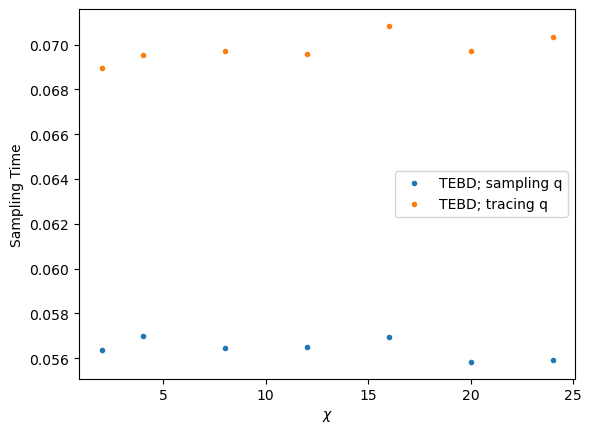

In [10]:
chis = list(datas_tebd.keys())
plt.plot(chis, [datas_tebd[c]['time_sq'] for c in chis], '.', label='TEBD; sampling q')
plt.plot(chis, [datas_tebd[c]['time_nsq'] for c in chis], '.', label='TEBD; tracing q')

plt.legend()
plt.xlabel(r'$\chi$')
plt.ylabel(r'Sampling Time')
plt.show()

At these small bond dimensions, $\chi \leq 24$, we do not see the expect scaling of sampling time with bond dimension. The transverse field Ising model is not complicated enough to generate large bond dimensions.

## Accuracy with increasing number of samples

Finally, we demonstrate that the error in expectation values from sampling decreases with the number of samples, as expected.

In [11]:
data_dict = {}
for ns in [10, 25, 50, 100, 250, 500]:
    data_tebd = imag_tebd(L=30, beta_max=3.0, num_samples=ns)
    data_dict[ns] = data_tebd

INFO:tenpy.tools.params:TFIChain: reading 'L'=30
INFO:tenpy.tools.params:TFIChain: reading 'J'=1.0
INFO:tenpy.tools.params:TFIChain: reading 'g'=1.2
INFO:tenpy.tools.params:PurificationTEBD: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:PurificationTEBD: reading 'dt'=0.05
INFO:tenpy.algorithms.tebd:Calculate U for {'order': 2, 'delta_t': 0.05, 'type_evo': 'imag', 'E_offset': None, 'tau': -0.05j}
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=100
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-08
INFO:tenpy.algorithms.purification:--> beta=0.050000, E_bond=-0.2460708907, max(S)=0.0172500676


[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


INFO:tenpy.algorithms.purification:--> beta=0.100000, E_bond=-0.4756494810, max(S)=0.0532230133


[4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]


INFO:tenpy.algorithms.purification:--> beta=0.150000, E_bond=-0.6767971387, max(S)=0.0967049734


[4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]


INFO:tenpy.algorithms.purification:--> beta=0.200000, E_bond=-0.8441540463, max(S)=0.1411322525


[4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4]


INFO:tenpy.algorithms.purification:--> beta=0.250000, E_bond=-0.9781014310, max(S)=0.1827168026


[4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4]


INFO:tenpy.algorithms.purification:--> beta=0.300000, E_bond=-1.0825193832, max(S)=0.2197692357


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4]


INFO:tenpy.algorithms.purification:--> beta=0.350000, E_bond=-1.1626430338, max(S)=0.2518978714


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4]


INFO:tenpy.algorithms.purification:--> beta=0.400000, E_bond=-1.2236704021, max(S)=0.2793931954


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 4]


INFO:tenpy.algorithms.purification:--> beta=0.450000, E_bond=-1.2701012984, max(S)=0.3028286284


[4, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 4]


INFO:tenpy.algorithms.purification:--> beta=0.500000, E_bond=-1.3055507972, max(S)=0.3228394786


[4, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.550000, E_bond=-1.3328003341, max(S)=0.3400180953


[4, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.600000, E_bond=-1.3539370350, max(S)=0.3548744861


[4, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.650000, E_bond=-1.3705056888, max(S)=0.3678296985


[4, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.700000, E_bond=-1.3836424298, max(S)=0.3792235056


[4, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 4]


INFO:tenpy.algorithms.purification:--> beta=0.750000, E_bond=-1.3941816805, max(S)=0.3893269224


[4, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 4]


INFO:tenpy.algorithms.purification:--> beta=0.800000, E_bond=-1.4027375341, max(S)=0.3983551258


[4, 14, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.850000, E_bond=-1.4097639705, max(S)=0.4064789719


[4, 14, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.900000, E_bond=-1.4155987119, max(S)=0.4138345776


[4, 14, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.950000, E_bond=-1.4204948992, max(S)=0.4205309982


[4, 15, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.000000, E_bond=-1.4246438890, max(S)=0.4266562471


[4, 15, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.050000, E_bond=-1.4281916571, max(S)=0.4322819578


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.100000, E_bond=-1.4312506260, max(S)=0.4374669712


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.150000, E_bond=-1.4339082234, max(S)=0.4422600875


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.200000, E_bond=-1.4362331074, max(S)=0.4467021777


[4, 16, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 22, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.250000, E_bond=-1.4382797204, max(S)=0.4508278067


[4, 16, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.300000, E_bond=-1.4400916437, max(S)=0.4546664848


[4, 16, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.350000, E_bond=-1.4417040858, max(S)=0.4582436383


[4, 16, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.400000, E_bond=-1.4431457429, max(S)=0.4615813653


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.450000, E_bond=-1.4444402010, max(S)=0.4646990279


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.500000, E_bond=-1.4456070009, max(S)=0.4676137204


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.tools.params:TFIChain: reading 'L'=30
INFO:tenpy.tools.params:TFIChain: reading 'J'=1.0
INFO:tenpy.tools.params:TFIChain: reading 'g'=1.2
INFO:tenpy.tools.params:PurificationTEBD: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:PurificationTEBD: reading 'dt'=0.05
INFO:tenpy.algorithms.tebd:Calculate U for {'order': 2, 'delta_t': 0.05, 'type_evo': 'imag', 'E_offset': None, 'tau': -0.05j}
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=100
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-08
INFO:tenpy.algorithms.purification:--> beta=0.050000, E_bond=-0.2460708907, max(S)=0.0172500676


[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


INFO:tenpy.algorithms.purification:--> beta=0.100000, E_bond=-0.4756494810, max(S)=0.0532230133


[4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]


INFO:tenpy.algorithms.purification:--> beta=0.150000, E_bond=-0.6767971387, max(S)=0.0967049734


[4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]


INFO:tenpy.algorithms.purification:--> beta=0.200000, E_bond=-0.8441540463, max(S)=0.1411322525


[4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4]


INFO:tenpy.algorithms.purification:--> beta=0.250000, E_bond=-0.9781014310, max(S)=0.1827168026


[4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4]


INFO:tenpy.algorithms.purification:--> beta=0.300000, E_bond=-1.0825193832, max(S)=0.2197692357


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4]


INFO:tenpy.algorithms.purification:--> beta=0.350000, E_bond=-1.1626430338, max(S)=0.2518978714


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4]


INFO:tenpy.algorithms.purification:--> beta=0.400000, E_bond=-1.2236704021, max(S)=0.2793931954


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 4]


INFO:tenpy.algorithms.purification:--> beta=0.450000, E_bond=-1.2701012984, max(S)=0.3028286284


[4, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 4]


INFO:tenpy.algorithms.purification:--> beta=0.500000, E_bond=-1.3055507972, max(S)=0.3228394786


[4, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.550000, E_bond=-1.3328003341, max(S)=0.3400180953


[4, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.600000, E_bond=-1.3539370350, max(S)=0.3548744861


[4, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.650000, E_bond=-1.3705056888, max(S)=0.3678296985


[4, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.700000, E_bond=-1.3836424298, max(S)=0.3792235056


[4, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 4]


INFO:tenpy.algorithms.purification:--> beta=0.750000, E_bond=-1.3941816805, max(S)=0.3893269224


[4, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 4]


INFO:tenpy.algorithms.purification:--> beta=0.800000, E_bond=-1.4027375341, max(S)=0.3983551258


[4, 14, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.850000, E_bond=-1.4097639705, max(S)=0.4064789719


[4, 14, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.900000, E_bond=-1.4155987119, max(S)=0.4138345776


[4, 14, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.950000, E_bond=-1.4204948992, max(S)=0.4205309982


[4, 15, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.000000, E_bond=-1.4246438890, max(S)=0.4266562471


[4, 15, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.050000, E_bond=-1.4281916571, max(S)=0.4322819578


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.100000, E_bond=-1.4312506260, max(S)=0.4374669712


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.150000, E_bond=-1.4339082234, max(S)=0.4422600875


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.200000, E_bond=-1.4362331074, max(S)=0.4467021777


[4, 16, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 22, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.250000, E_bond=-1.4382797204, max(S)=0.4508278067


[4, 16, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.300000, E_bond=-1.4400916437, max(S)=0.4546664848


[4, 16, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.350000, E_bond=-1.4417040858, max(S)=0.4582436383


[4, 16, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.400000, E_bond=-1.4431457429, max(S)=0.4615813653


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.450000, E_bond=-1.4444402010, max(S)=0.4646990279


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.500000, E_bond=-1.4456070009, max(S)=0.4676137204


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.tools.params:TFIChain: reading 'L'=30
INFO:tenpy.tools.params:TFIChain: reading 'J'=1.0
INFO:tenpy.tools.params:TFIChain: reading 'g'=1.2
INFO:tenpy.tools.params:PurificationTEBD: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:PurificationTEBD: reading 'dt'=0.05
INFO:tenpy.algorithms.tebd:Calculate U for {'order': 2, 'delta_t': 0.05, 'type_evo': 'imag', 'E_offset': None, 'tau': -0.05j}
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=100
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-08
INFO:tenpy.algorithms.purification:--> beta=0.050000, E_bond=-0.2460708907, max(S)=0.0172500676


[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


INFO:tenpy.algorithms.purification:--> beta=0.100000, E_bond=-0.4756494810, max(S)=0.0532230133


[4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]


INFO:tenpy.algorithms.purification:--> beta=0.150000, E_bond=-0.6767971387, max(S)=0.0967049734


[4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]


INFO:tenpy.algorithms.purification:--> beta=0.200000, E_bond=-0.8441540463, max(S)=0.1411322525


[4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4]


INFO:tenpy.algorithms.purification:--> beta=0.250000, E_bond=-0.9781014310, max(S)=0.1827168026


[4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4]


INFO:tenpy.algorithms.purification:--> beta=0.300000, E_bond=-1.0825193832, max(S)=0.2197692357


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4]


INFO:tenpy.algorithms.purification:--> beta=0.350000, E_bond=-1.1626430338, max(S)=0.2518978714


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4]


INFO:tenpy.algorithms.purification:--> beta=0.400000, E_bond=-1.2236704021, max(S)=0.2793931954


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 4]


INFO:tenpy.algorithms.purification:--> beta=0.450000, E_bond=-1.2701012984, max(S)=0.3028286284


[4, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 4]


INFO:tenpy.algorithms.purification:--> beta=0.500000, E_bond=-1.3055507972, max(S)=0.3228394786


[4, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.550000, E_bond=-1.3328003341, max(S)=0.3400180953


[4, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.600000, E_bond=-1.3539370350, max(S)=0.3548744861


[4, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.650000, E_bond=-1.3705056888, max(S)=0.3678296985


[4, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.700000, E_bond=-1.3836424298, max(S)=0.3792235056


[4, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 4]


INFO:tenpy.algorithms.purification:--> beta=0.750000, E_bond=-1.3941816805, max(S)=0.3893269224


[4, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 4]


INFO:tenpy.algorithms.purification:--> beta=0.800000, E_bond=-1.4027375341, max(S)=0.3983551258


[4, 14, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.850000, E_bond=-1.4097639705, max(S)=0.4064789719


[4, 14, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.900000, E_bond=-1.4155987119, max(S)=0.4138345776


[4, 14, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.950000, E_bond=-1.4204948992, max(S)=0.4205309982


[4, 15, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.000000, E_bond=-1.4246438890, max(S)=0.4266562471


[4, 15, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.050000, E_bond=-1.4281916571, max(S)=0.4322819578


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.100000, E_bond=-1.4312506260, max(S)=0.4374669712


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.150000, E_bond=-1.4339082234, max(S)=0.4422600875


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.200000, E_bond=-1.4362331074, max(S)=0.4467021777


[4, 16, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 22, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.250000, E_bond=-1.4382797204, max(S)=0.4508278067


[4, 16, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.300000, E_bond=-1.4400916437, max(S)=0.4546664848


[4, 16, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.350000, E_bond=-1.4417040858, max(S)=0.4582436383


[4, 16, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.400000, E_bond=-1.4431457429, max(S)=0.4615813653


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.450000, E_bond=-1.4444402010, max(S)=0.4646990279


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.500000, E_bond=-1.4456070009, max(S)=0.4676137204


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.tools.params:TFIChain: reading 'L'=30
INFO:tenpy.tools.params:TFIChain: reading 'J'=1.0
INFO:tenpy.tools.params:TFIChain: reading 'g'=1.2
INFO:tenpy.tools.params:PurificationTEBD: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:PurificationTEBD: reading 'dt'=0.05
INFO:tenpy.algorithms.tebd:Calculate U for {'order': 2, 'delta_t': 0.05, 'type_evo': 'imag', 'E_offset': None, 'tau': -0.05j}
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=100
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-08
INFO:tenpy.algorithms.purification:--> beta=0.050000, E_bond=-0.2460708907, max(S)=0.0172500676


[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


INFO:tenpy.algorithms.purification:--> beta=0.100000, E_bond=-0.4756494810, max(S)=0.0532230133


[4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]


INFO:tenpy.algorithms.purification:--> beta=0.150000, E_bond=-0.6767971387, max(S)=0.0967049734


[4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]


INFO:tenpy.algorithms.purification:--> beta=0.200000, E_bond=-0.8441540463, max(S)=0.1411322525


[4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4]


INFO:tenpy.algorithms.purification:--> beta=0.250000, E_bond=-0.9781014310, max(S)=0.1827168026


[4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4]


INFO:tenpy.algorithms.purification:--> beta=0.300000, E_bond=-1.0825193832, max(S)=0.2197692357


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4]


INFO:tenpy.algorithms.purification:--> beta=0.350000, E_bond=-1.1626430338, max(S)=0.2518978714


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4]


INFO:tenpy.algorithms.purification:--> beta=0.400000, E_bond=-1.2236704021, max(S)=0.2793931954


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 4]


INFO:tenpy.algorithms.purification:--> beta=0.450000, E_bond=-1.2701012984, max(S)=0.3028286284


[4, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 4]


INFO:tenpy.algorithms.purification:--> beta=0.500000, E_bond=-1.3055507972, max(S)=0.3228394786


[4, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.550000, E_bond=-1.3328003341, max(S)=0.3400180953


[4, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.600000, E_bond=-1.3539370350, max(S)=0.3548744861


[4, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.650000, E_bond=-1.3705056888, max(S)=0.3678296985


[4, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.700000, E_bond=-1.3836424298, max(S)=0.3792235056


[4, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 4]


INFO:tenpy.algorithms.purification:--> beta=0.750000, E_bond=-1.3941816805, max(S)=0.3893269224


[4, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 4]


INFO:tenpy.algorithms.purification:--> beta=0.800000, E_bond=-1.4027375341, max(S)=0.3983551258


[4, 14, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.850000, E_bond=-1.4097639705, max(S)=0.4064789719


[4, 14, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.900000, E_bond=-1.4155987119, max(S)=0.4138345776


[4, 14, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.950000, E_bond=-1.4204948992, max(S)=0.4205309982


[4, 15, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.000000, E_bond=-1.4246438890, max(S)=0.4266562471


[4, 15, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.050000, E_bond=-1.4281916571, max(S)=0.4322819578


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.100000, E_bond=-1.4312506260, max(S)=0.4374669712


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.150000, E_bond=-1.4339082234, max(S)=0.4422600875


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.200000, E_bond=-1.4362331074, max(S)=0.4467021777


[4, 16, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 22, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.250000, E_bond=-1.4382797204, max(S)=0.4508278067


[4, 16, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.300000, E_bond=-1.4400916437, max(S)=0.4546664848


[4, 16, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.350000, E_bond=-1.4417040858, max(S)=0.4582436383


[4, 16, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.400000, E_bond=-1.4431457429, max(S)=0.4615813653


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.450000, E_bond=-1.4444402010, max(S)=0.4646990279


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.500000, E_bond=-1.4456070009, max(S)=0.4676137204


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.tools.params:TFIChain: reading 'L'=30
INFO:tenpy.tools.params:TFIChain: reading 'J'=1.0
INFO:tenpy.tools.params:TFIChain: reading 'g'=1.2
INFO:tenpy.tools.params:PurificationTEBD: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:PurificationTEBD: reading 'dt'=0.05
INFO:tenpy.algorithms.tebd:Calculate U for {'order': 2, 'delta_t': 0.05, 'type_evo': 'imag', 'E_offset': None, 'tau': -0.05j}
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=100
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-08
INFO:tenpy.algorithms.purification:--> beta=0.050000, E_bond=-0.2460708907, max(S)=0.0172500676


[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


INFO:tenpy.algorithms.purification:--> beta=0.100000, E_bond=-0.4756494810, max(S)=0.0532230133


[4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]


INFO:tenpy.algorithms.purification:--> beta=0.150000, E_bond=-0.6767971387, max(S)=0.0967049734


[4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]


INFO:tenpy.algorithms.purification:--> beta=0.200000, E_bond=-0.8441540463, max(S)=0.1411322525


[4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4]


INFO:tenpy.algorithms.purification:--> beta=0.250000, E_bond=-0.9781014310, max(S)=0.1827168026


[4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4]


INFO:tenpy.algorithms.purification:--> beta=0.300000, E_bond=-1.0825193832, max(S)=0.2197692357


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4]


INFO:tenpy.algorithms.purification:--> beta=0.350000, E_bond=-1.1626430338, max(S)=0.2518978714


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4]


INFO:tenpy.algorithms.purification:--> beta=0.400000, E_bond=-1.2236704021, max(S)=0.2793931954


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 4]


INFO:tenpy.algorithms.purification:--> beta=0.450000, E_bond=-1.2701012984, max(S)=0.3028286284


[4, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 4]


INFO:tenpy.algorithms.purification:--> beta=0.500000, E_bond=-1.3055507972, max(S)=0.3228394786


[4, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.550000, E_bond=-1.3328003341, max(S)=0.3400180953


[4, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.600000, E_bond=-1.3539370350, max(S)=0.3548744861


[4, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.650000, E_bond=-1.3705056888, max(S)=0.3678296985


[4, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.700000, E_bond=-1.3836424298, max(S)=0.3792235056


[4, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 4]


INFO:tenpy.algorithms.purification:--> beta=0.750000, E_bond=-1.3941816805, max(S)=0.3893269224


[4, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 4]


INFO:tenpy.algorithms.purification:--> beta=0.800000, E_bond=-1.4027375341, max(S)=0.3983551258


[4, 14, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.850000, E_bond=-1.4097639705, max(S)=0.4064789719


[4, 14, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.900000, E_bond=-1.4155987119, max(S)=0.4138345776


[4, 14, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.950000, E_bond=-1.4204948992, max(S)=0.4205309982


[4, 15, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.000000, E_bond=-1.4246438890, max(S)=0.4266562471


[4, 15, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.050000, E_bond=-1.4281916571, max(S)=0.4322819578


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.100000, E_bond=-1.4312506260, max(S)=0.4374669712


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.150000, E_bond=-1.4339082234, max(S)=0.4422600875


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.200000, E_bond=-1.4362331074, max(S)=0.4467021777


[4, 16, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 22, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.250000, E_bond=-1.4382797204, max(S)=0.4508278067


[4, 16, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.300000, E_bond=-1.4400916437, max(S)=0.4546664848


[4, 16, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.350000, E_bond=-1.4417040858, max(S)=0.4582436383


[4, 16, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.400000, E_bond=-1.4431457429, max(S)=0.4615813653


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.450000, E_bond=-1.4444402010, max(S)=0.4646990279


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.500000, E_bond=-1.4456070009, max(S)=0.4676137204


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.tools.params:TFIChain: reading 'L'=30
INFO:tenpy.tools.params:TFIChain: reading 'J'=1.0
INFO:tenpy.tools.params:TFIChain: reading 'g'=1.2
INFO:tenpy.tools.params:PurificationTEBD: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:PurificationTEBD: reading 'dt'=0.05
INFO:tenpy.algorithms.tebd:Calculate U for {'order': 2, 'delta_t': 0.05, 'type_evo': 'imag', 'E_offset': None, 'tau': -0.05j}
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=100
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-08
INFO:tenpy.algorithms.purification:--> beta=0.050000, E_bond=-0.2460708907, max(S)=0.0172500676


[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


INFO:tenpy.algorithms.purification:--> beta=0.100000, E_bond=-0.4756494810, max(S)=0.0532230133


[4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]


INFO:tenpy.algorithms.purification:--> beta=0.150000, E_bond=-0.6767971387, max(S)=0.0967049734


[4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]


INFO:tenpy.algorithms.purification:--> beta=0.200000, E_bond=-0.8441540463, max(S)=0.1411322525


[4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4]


INFO:tenpy.algorithms.purification:--> beta=0.250000, E_bond=-0.9781014310, max(S)=0.1827168026


[4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4]


INFO:tenpy.algorithms.purification:--> beta=0.300000, E_bond=-1.0825193832, max(S)=0.2197692357


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4]


INFO:tenpy.algorithms.purification:--> beta=0.350000, E_bond=-1.1626430338, max(S)=0.2518978714


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4]


INFO:tenpy.algorithms.purification:--> beta=0.400000, E_bond=-1.2236704021, max(S)=0.2793931954


[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 4]


INFO:tenpy.algorithms.purification:--> beta=0.450000, E_bond=-1.2701012984, max(S)=0.3028286284


[4, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 4]


INFO:tenpy.algorithms.purification:--> beta=0.500000, E_bond=-1.3055507972, max(S)=0.3228394786


[4, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.550000, E_bond=-1.3328003341, max(S)=0.3400180953


[4, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.600000, E_bond=-1.3539370350, max(S)=0.3548744861


[4, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.650000, E_bond=-1.3705056888, max(S)=0.3678296985


[4, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 4]


INFO:tenpy.algorithms.purification:--> beta=0.700000, E_bond=-1.3836424298, max(S)=0.3792235056


[4, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 4]


INFO:tenpy.algorithms.purification:--> beta=0.750000, E_bond=-1.3941816805, max(S)=0.3893269224


[4, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 4]


INFO:tenpy.algorithms.purification:--> beta=0.800000, E_bond=-1.4027375341, max(S)=0.3983551258


[4, 14, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.850000, E_bond=-1.4097639705, max(S)=0.4064789719


[4, 14, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.900000, E_bond=-1.4155987119, max(S)=0.4138345776


[4, 14, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 14, 4]


INFO:tenpy.algorithms.purification:--> beta=0.950000, E_bond=-1.4204948992, max(S)=0.4205309982


[4, 15, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.000000, E_bond=-1.4246438890, max(S)=0.4266562471


[4, 15, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.050000, E_bond=-1.4281916571, max(S)=0.4322819578


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 15, 4]


INFO:tenpy.algorithms.purification:--> beta=1.100000, E_bond=-1.4312506260, max(S)=0.4374669712


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.150000, E_bond=-1.4339082234, max(S)=0.4422600875


[4, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.200000, E_bond=-1.4362331074, max(S)=0.4467021777


[4, 16, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 22, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.250000, E_bond=-1.4382797204, max(S)=0.4508278067


[4, 16, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.300000, E_bond=-1.4400916437, max(S)=0.4546664848


[4, 16, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.350000, E_bond=-1.4417040858, max(S)=0.4582436383


[4, 16, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 23, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.400000, E_bond=-1.4431457429, max(S)=0.4615813653


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.450000, E_bond=-1.4444402010, max(S)=0.4646990279


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


INFO:tenpy.algorithms.purification:--> beta=1.500000, E_bond=-1.4456070009, max(S)=0.4676137204


[4, 16, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 4]


/home/sajant/tenpy/tenpy/tools/params.py:232: UserWarning: unused options for config PurificationTEBD:
['N_steps', 'order']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


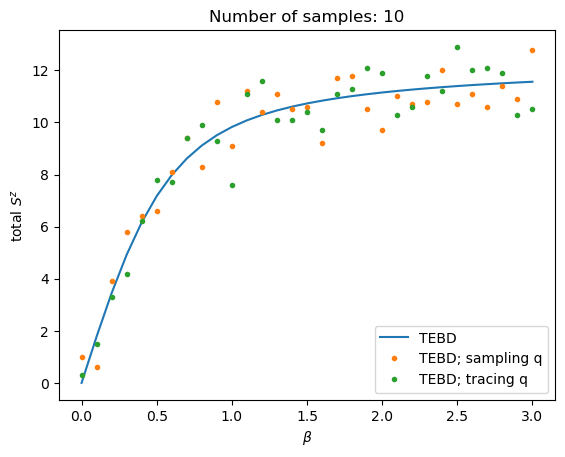

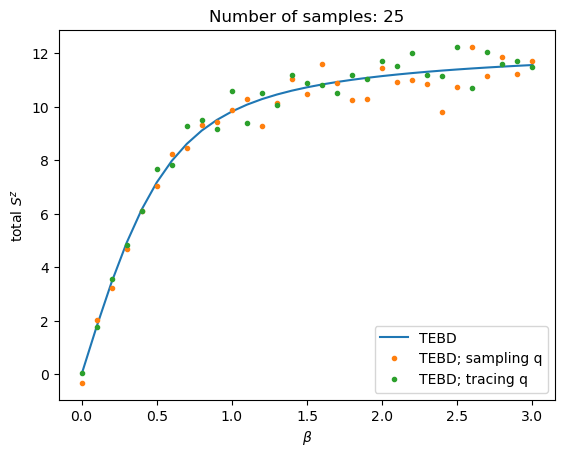

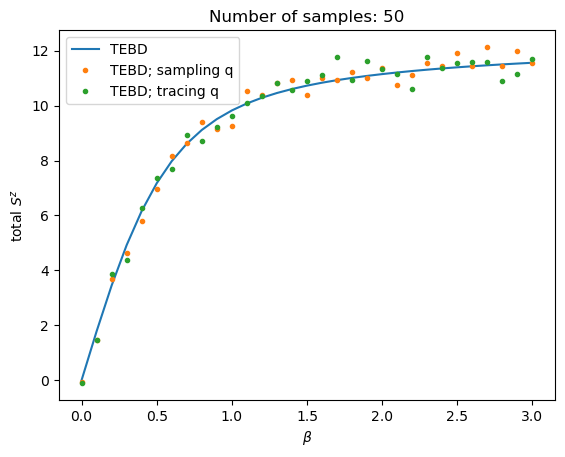

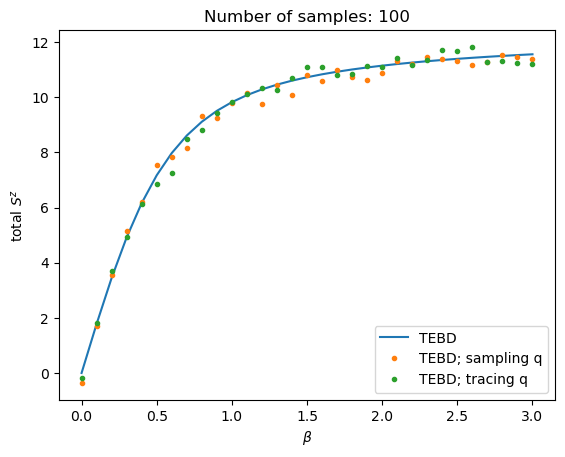

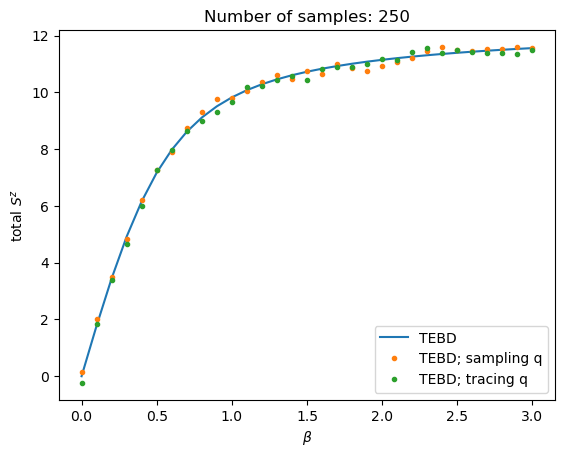

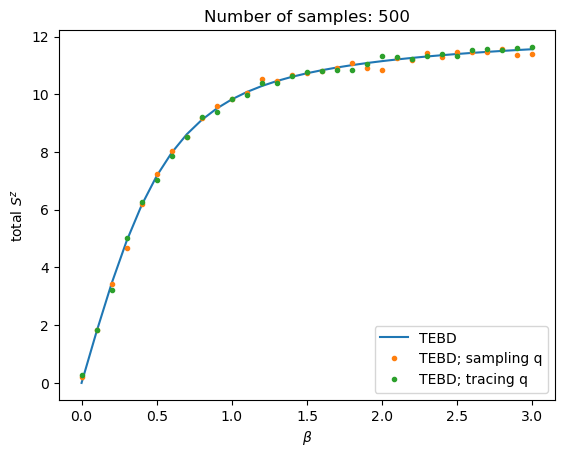

In [12]:
for ns in [10, 25, 50, 100, 250, 500]:
    plt.plot(data_dict[ns]['beta'], np.sum(data_dict[ns]['Sz'], axis=1), label='TEBD')
    plt.plot(data_dict[ns]['beta'], np.sum(data_dict[ns]['Sz_sample_sq'], axis=1), '.', label='TEBD; sampling q')
    plt.plot(data_dict[ns]['beta'], np.sum(data_dict[ns]['Sz_sample_nsq'], axis=1), '.', label='TEBD; tracing q')
    
    plt.legend()
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'total $S^z$')
    plt.title(f"Number of samples: {ns}")
    plt.show()

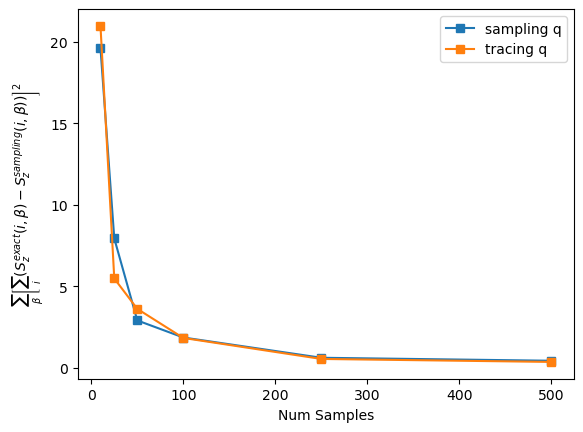

In [13]:
plt.plot([10, 25, 50, 100, 250, 500], 
         [np.power(np.sum(data_dict[ns]['Sz'], axis=1) - np.sum(data_dict[ns]['Sz_sample_sq'], axis=1), 2).sum() for ns in[10, 25, 50, 100, 250, 500]],
        marker='s', label='sampling q')
plt.plot([10, 25, 50, 100, 250, 500], 
         [np.power(np.sum(data_dict[ns]['Sz'], axis=1) - np.sum(data_dict[ns]['Sz_sample_nsq'], axis=1), 2).sum() for ns in[10, 25, 50, 100, 250, 500]],
        marker='s', label='tracing q')

plt.legend()
plt.xlabel(r'Num Samples')
plt.ylabel(r'$\sum_\beta \left[\sum_i (S_z^{exact}(i,\beta) - S_z^{sampling}(i,\beta))\right]^2$')
plt.show()